#Package importation

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'all_kindle_review .csv'				 CustomerChurn_dataset.gsheet
 amazon_reviews.txt					 exam.csv
 archive.zip						 fraud_dataset.csv
 Arrest_Data_from_2010_to_Present.csv			'Intro to AI'
'Career Mode female player datasets - FIFA 16-22.xlsx'	'preprocessed_kindle_review .csv'
'Colab Notebooks'					 Reviews.csv
 CustomerChurn_dataset.csv


Global constants and functions to be later employed

In [ ]:
DATASET_SRC = '/content/drive/My Drive/Reviews.csv'
CODE_TO_SENTIMENT = {0: 'Negative', 2: 'Positive'}
CLEANING_REGEX = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
TRAIN_SIZE = 0.75
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

def load_data(src):
  df = pd.read_csv(src)
  return df

def sentiment_decoder(score):
  if score > 3:
    return CODE_TO_SENTIMENT[2]
  return CODE_TO_SENTIMENT[0]

def clean(text):
  stop_words = stopwords.words('english')
  text = text.lower()
  text = re.sub(CLEANING_REGEX, ' ', text)
  text = " ".join(i for i in text.split() if i not in stop_words)
  return text


Load dataset

In [ ]:
product_reviews = load_data(DATASET_SRC)
product_reviews.head(15)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


Data preprocessing

In [ ]:
# Remove unnecessary columns from the dataset
product_reviews = product_reviews[['Score','Text']]

# Convert sentiment scores into sentiment decodings
product_reviews['Score'] = product_reviews['Score'].apply(lambda score : sentiment_decoder(score))

# Clean the text data by removing unnecessary characters and converting to lowercase
product_reviews['Cleaned'] = product_reviews['Text'].apply(lambda text: clean(text))

product_reviews.head()

,Score,Text,Cleaned
0,Positive,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Negative,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,Positive,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,Negative,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Positive,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


Split

In [ ]:
# Divide the dataset into training and testing data
train_data, test_data = train_test_split(product_reviews,
                                         test_size = 1-TRAIN_SIZE,
                                         random_state=7)

# Print the size of the training and testing datasets
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

# Display the first 10 rows of the training dataset
train_data.head(10)

Train Data size: 426340
Test Data size 142114


,Score,Text,Cleaned
554620,Positive,the haribo gummi letters are great.exactly the...,haribo gummi letters great exactly way gummi c...
448180,Positive,"<a href=""http://www.amazon.com/gp/product/B002...",href bean direct fair trade espresso whole bea...
171555,Positive,this tastes like home made beef jerky to me. t...,tastes like home made beef jerky also ton one ...
125009,Positive,These have become my favorite candy! I don't k...,become favorite candy know love 2 us easily go...
512286,Negative,I didn't like it - very strong smell - too str...,like strong smell strong smelled like campfire...
182112,Positive,"I've enjoyed this product for several years, a...",enjoyed product several years convenient able ...
453468,Positive,This coffee is great! If you are a coffee drin...,coffee great coffee drinker need bright bushy ...
408550,Positive,"I'm really, really pleased with this bread mac...",really really pleased bread machine mix first ...
382312,Positive,Do you have an elderly kitty who has trouble k...,elderly kitty trouble keeping weight reason fi...
508891,Positive,Was scared to try it because of its color and ...,scared try color expected taste tryed tastes w...


#Exploratory data analysis

,Score,Text,Cleaned
0,1,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,0,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,1,This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,0,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,1,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
...,...,...,...
568449,1,Great for sesame chicken..this is a good if no...,great sesame chicken good better resturants ea...
568450,0,I'm disappointed with the flavor. The chocolat...,disappointed flavor chocolate notes especially...
568451,1,"These stars are small, so you can give 10-15 o...",stars small give 10 15 one training session tr...
568452,1,These are the BEST treats for training and rew...,best treats training rewarding dog good groomi...


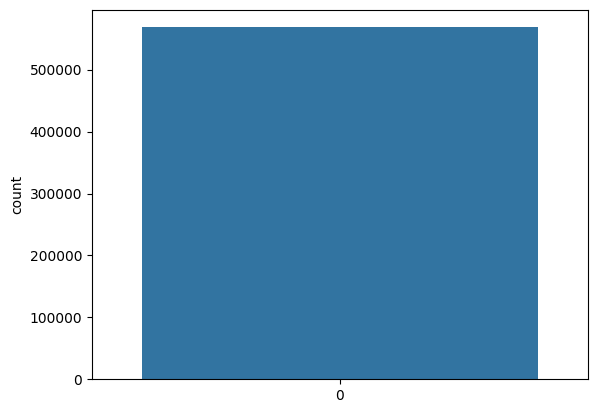

In [ ]:
sns.countplot(product_reviews['Score'])
product_reviews

Positive words using word cloud

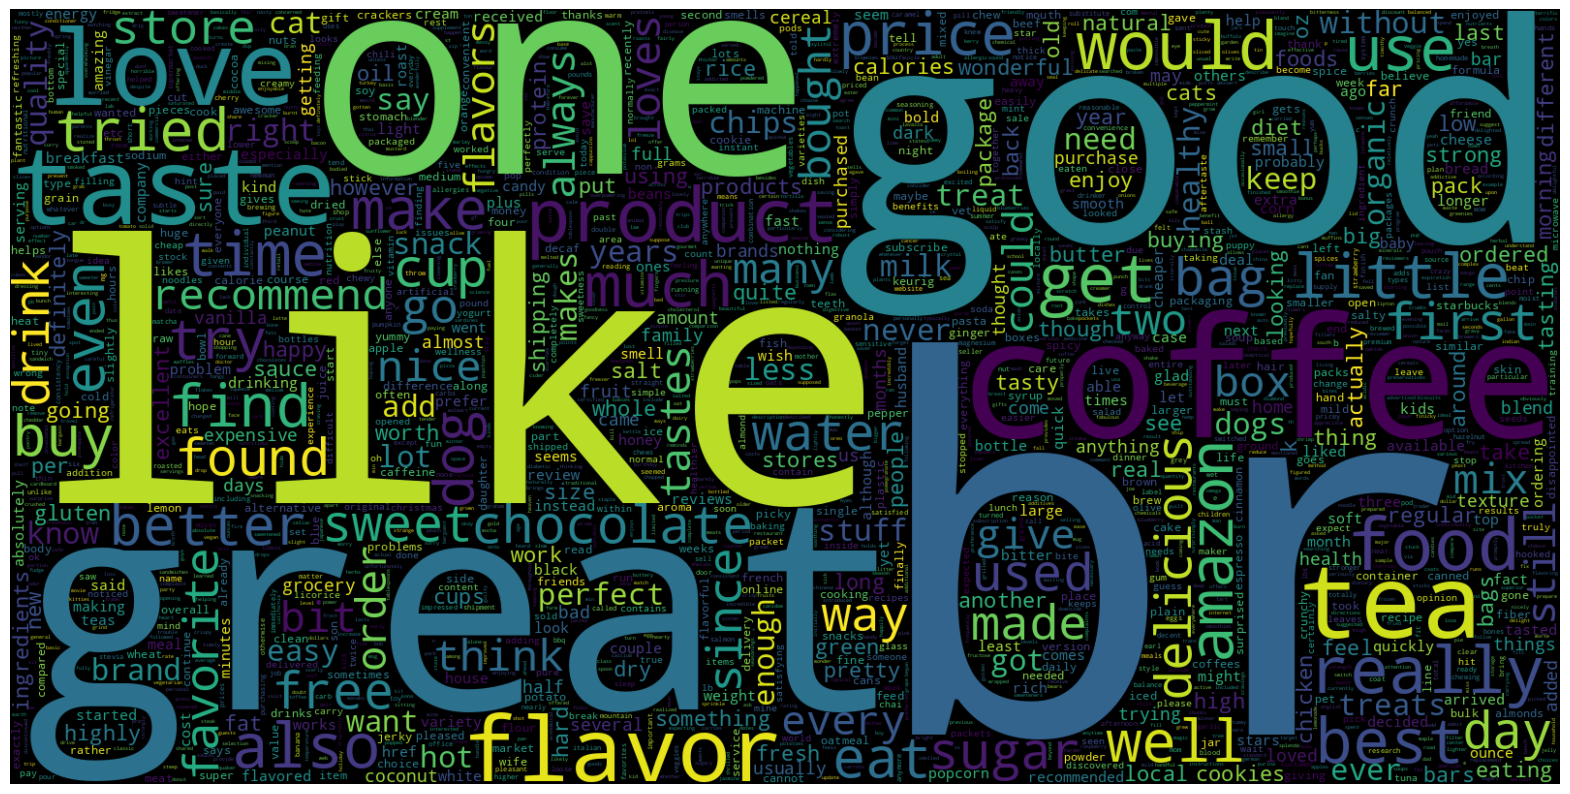

In [ ]:
#Remove unwanted characters, digits, and whitespace from the text
cleaned_text = []
for review in product_reviews.Cleaned:
    review = re.sub(r'\d+', '', review)
    review = re.sub(r'\W+', ' ', review)
    cleaned_text.append(review)

# Filter positive reviews
positive_reviews = [review for review, score in zip(cleaned_text, product_reviews['Score']) if score == 1]


# Generate the word cloud
from collections import Counter
from wordcloud import WordCloud

# Count word occurrences in positive_reviews
word_counts = Counter(" ".join(positive_reviews).split())

# Generate word cloud from word_counts
wc = WordCloud(max_words=2000, width=1600, height=800).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize = (20,20))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

Negative words using word cloud

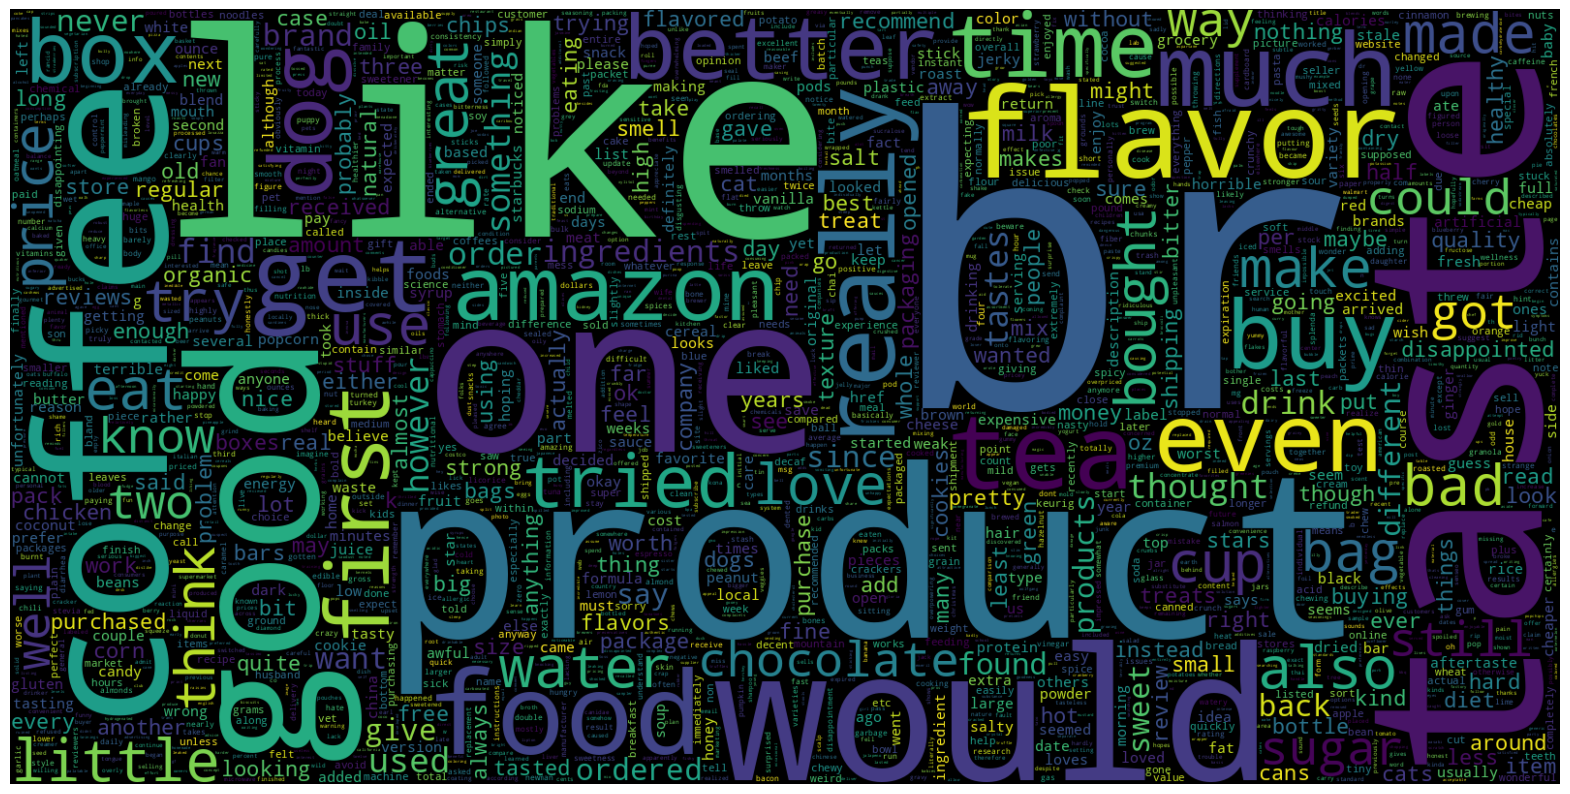

In [ ]:
#Remove unwanted characters, digits, and whitespace from the text
cleaned_text = []
for review in product_reviews.Cleaned:
    review = re.sub(r'\d+', '', review)
    review = re.sub(r'\W+', ' ', review)
    cleaned_text.append(review)

# Filter negative reviews
negative_reviews = [review for review, score in zip(cleaned_text, product_reviews['Score']) if score == 0]


# Generate the word cloud
from collections import Counter
from wordcloud import WordCloud

# Count word occurrences in positive_reviews
word_counts = Counter(" ".join(negative_reviews).split())

# Generate word cloud from word_counts
wc = WordCloud(max_words=2000, width=1600, height=800).generate_from_frequencies(word_counts)

# Display the word cloud
plt.figure(figsize = (20,20))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.show()

Sentence tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer

# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.Cleaned)

# Create a dictionary of words and their indices
word_index = tokenizer.word_index

# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

# Save the tokenizer object
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Vocabulary Size : 99094


Word sequence padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Transform the reviews to sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Cleaned),
                        maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Cleaned),
                       maxlen=MAX_SEQUENCE_LENGTH)

# Print the shapes of the transformed sequences
print("Training X Shape:", x_train.shape)
print("Testing X Shape:", x_test.shape)
print(x_train)

Training X Shape: (426340, 30)
Testing X Shape: (142114, 30)
[[    0     0     0 ...    57   358    42]
 [    0     0     0 ...    94    13    22]
 [   18  1926     4 ...    48   156    39]
 ...
 [    0     0     0 ...   214  4776   300]
 [  590    56   115 ...   576    20   131]
 [    0     0     0 ...    12 99093   133]]


Label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the training data's scores
encoder.fit(train_data.Score.to_list())

# Transform the training and testing data's scores
y_train = encoder.transform(train_data.Score.to_list())
y_test = encoder.transform(test_data.Score.to_list())

# Reshape the y_train and y_test arrays to be 2D arrays
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Print the shapes of the transformed y_train and y_test arrays
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (426340, 1)
y_test shape: (142114, 1)


Hyperparameter embedding

In [ ]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

Layer for Word embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-12-03 15:57:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-03 15:57:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-03 15:57:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

#Model training

Import necessary packages

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

The LSTM model

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

Train on GPU

In [ ]:
print("Training on GPU...") if tf.config.list_physical_devices('GPU') else print("Training on CPU...")

Training on CPU...


In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
417/417 [==============================] - 538s 1s/step - loss: 0.2256 - accuracy: 0.9089 - val_loss: 0.2408 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 2/10
417/417 [==============================] - 583s 1s/step - loss: 0.2225 - accuracy: 0.9094 - val_loss: 0.2408 - val_accuracy: 0.9037 - lr: 0.0010
Epoch 3/10
417/417 [==============================] - 547s 1s/step - loss: 0.2190 - accuracy: 0.9114 - val_loss: 0.2438 - val_accuracy: 0.9010 - lr: 0.0010
Epoch 4/10
417/417 [==============================] - 547s 1s/step - loss: 0.2169 - accuracy: 0.9125 - val_loss: 0.2415 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 5/10
417/417 [==============================] - 541s 1s/step - loss: 0.2156 - accuracy: 0.9131 - val_loss: 0.2395 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 6/10
417/417 [==============================] - 526s 1s/step - loss: 0.2131 - accuracy: 0.9143 - val_loss: 0.2422 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 7/10
417/417 [==============================] - 520s 1s/st

#Testing and validation

In [ ]:
sample = ["The staff was great. The receptionists were very helpful and answered all our questions. The room was clean and bright, and room service was always on time. Will be coming back!”"]
sample = pad_sequences(tokenizer.texts_to_sequences(sample),
                        maxlen = MAX_SEQUENCE_LENGTH)

def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


score = model.predict(sample, verbose=1, batch_size=1)
print(score, decode_sentiment(score))


1/1 [==============================] - 0s 30ms/step
[[0.96828395]] Positive


#Save the model


In [ ]:
filename = 'product-rev-sent-v1.2.h5'
model.save(filename)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


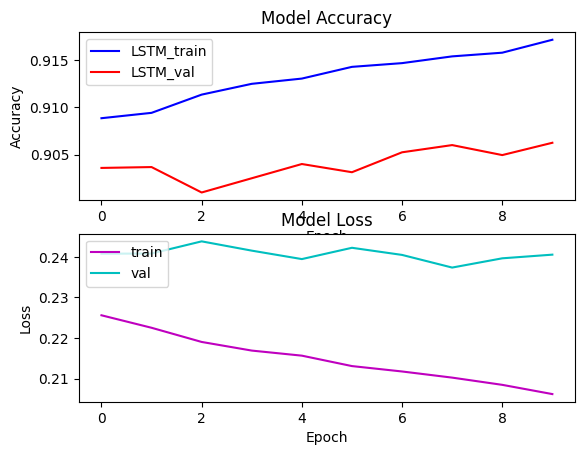

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1)

axes[0].plot(history.history['accuracy'], color='b')
axes[0].plot(history.history['val_accuracy'], color='r')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')

axes[1].plot(history.history['loss'], color='m')
axes[1].plot(history.history['val_loss'], color='c')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

15/15 [==============================] - 41s 3s/step


Confusion Matrix and classification report

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

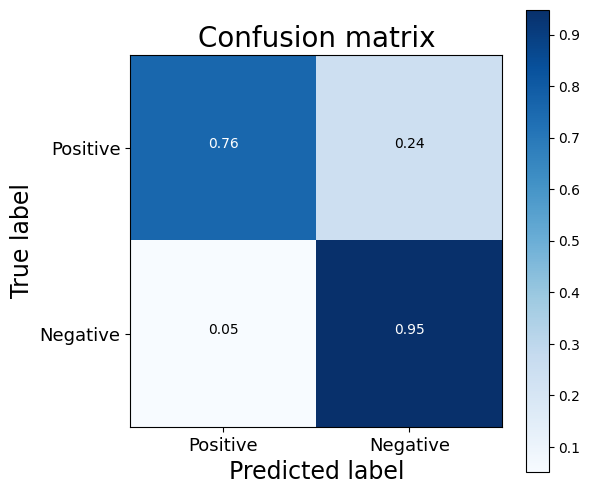

In [ ]:
cnf_matrix = confusion_matrix(test_data.Score.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.Score.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(list(test_data.Score), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78     31184
    Positive       0.93      0.95      0.94    110930

    accuracy                           0.91    142114
   macro avg       0.87      0.85      0.86    142114
weighted avg       0.90      0.91      0.91    142114

